In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch
from torch.nn.functional import grid_sample

In [3]:
def v_to_phii(xv,v, interp2d=False):
    '''
    Use Euler's method to construct a position field from a velocity field
    by integrating over time.
    
    This method uses interpolation and subtracts and adds identity for better
    behavior outside boundaries. This method is sometimes refered to as the
    method of characteristics.
    
    Parameters
    ----------
    xv : list of 1D tensors
        xv[i] is a tensor storing the location of the sample points along
        the i-th dimension of v
    v : 5D tensor
        5D tensor where first axis corresponds to time, second corresponds to 
        component, and 3rd to 5th correspond to spatial dimensions.
    
    Returns
    -------    
    phii : 4D tensor
        Inverse transformation is output with component on the first dimension
        and space on the last 3. Note that the whole timeseries is not output.
    
    '''
    XV = torch.stack(torch.meshgrid(xv,indexing='ij'))
    phii = torch.clone(XV)
    dt = 1.0/v.shape[0]
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt
        phii = interp(xv,phii-XV,Xs, interp2d=interp2d)+Xs
    return phii


def interp(x, I, phii, interp2d=False, **kwargs):
    '''
    Interpolate an image with specified regular voxel locations at specified sample points.
    
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D or 4D arrays with first channel storing component)
    
    Parameters
    ----------
    x : list of numpy arrays
        x[i] is a numpy array storing the pixel locations of imaging data along the i-th axis.
        Note that this MUST be regularly spaced, only the first and last values are queried.
    I : array
        Numpy array or torch tensor storing 2D or 3D imaging data.  In the 3D case, I is a 4D array with 
        channels along the first axis and spatial dimensions along the last 3. For 2D, I is a 3D array with
        spatial dimensions along the last 2.
    phii : array
        Numpy array or torch tensor storing positions of the sample points. phii is a 3D or 4D array
        with components along the first axis (e.g. x0,x1,x1) and spatial dimensions 
        along the last axes.
    interp2d : bool, optional
        If True, interpolates a 2D image, otherwise 3D. Default is False (expects a 3D image).
    kwargs : dict
        keword arguments to be passed to the grid sample function. For example
        to specify interpolation type like nearest.  See pytorch grid_sample documentation.
    
    Returns
    -------
    out : torch tensor
        Array storing an image with channels stored along the first axis. 
        This is the input image resampled at the points stored in phii.


    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    ndim = 2 if interp2d==True else 3
    for i in range(ndim):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    # feb 2022
    if 'padding_mode' not in kwargs:
        kwargs['padding_mode'] = 'border' # note that default is zero
    if interp2d==True:
        phii = phii.flip(0).permute((1,2,0))[None]
    else:
        phii = phii.flip(0).permute((1,2,3,0))[None]
    out = grid_sample(I[None], phii, align_corners=True, **kwargs)

    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension
    out = out[0]
    return out

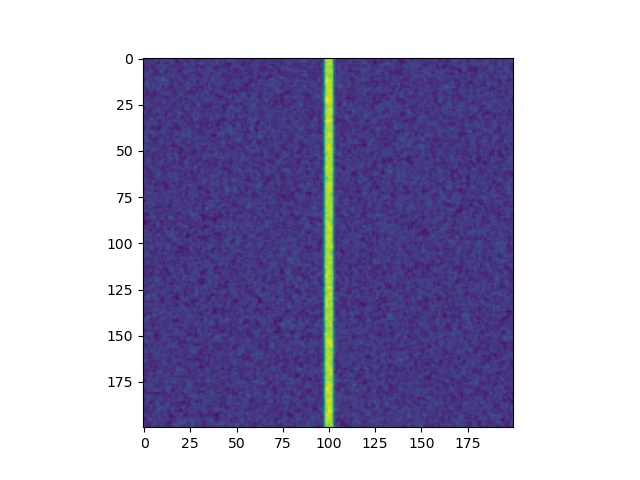

In [9]:
SIZEX = 200
SIZEY = 200
rng = np.random.default_rng()
dI = np.array((1.0,1.0))
nI = np.array((SIZEY,SIZEX))
xI = [np.arange(n)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI, indexing='ij'), -1)

line = (np.abs(0*XI[...,0] - XI[...,1] + 100)  < 3.0)
noise = rng.standard_normal(nI)*0.1
img1 = noise + line
img1 = gaussian_filter(img1, 0.6)

plt.figure()
plt.imshow(img1)

In [10]:
nv = np.array((SIZEY,SIZEX))
xv = [np.arange(x).astype(float) for x in nv]
xv = [torch.from_numpy(x) for x in xv]
for i in range(100):
    v = gaussian_filter(rng.standard_normal((1,2,SIZEY,SIZEX))*150,8)
    v = torch.from_numpy(v)
    phi = v_to_phii(xv, v, interp2d=True)
    line2 = interp(xI,line[None].astype(float),phi, interp2d=True)
    img2 = torch.from_numpy(noise) + line2
    img2 = gaussian_filter(img2,0.6)
    np.save(f'/home/brysongray/tractography/data/synthetic_tracts/line_{i}', img2)

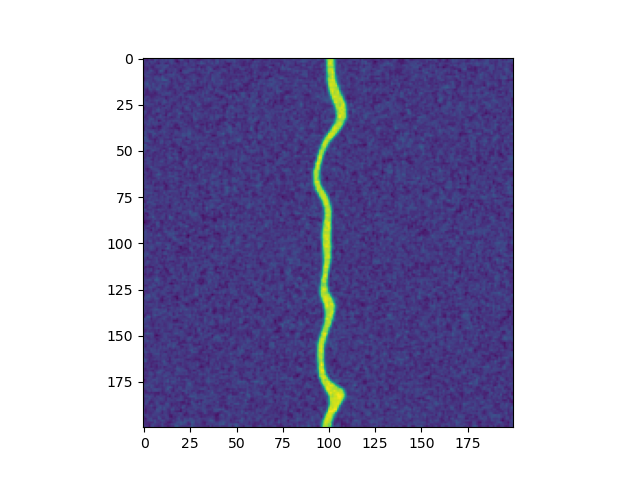

In [11]:
plt.figure()
plt.imshow(img2[0])